**MASTER'S DEGREE IN APPLIED ARTIFICIAL INTELLIGENCE**.

**Course: TC5035.10 - Integration project**

Tecnológico de Monterrey

Professor Dr. Horacio Martínez Alfaro

**Week 6, Activity 5**

Final Model

---

*   **Student:** Jorge Antonio Acosta Rosales
*   **Registration:** A01381552
*   **Student:** Israel Luján González
*   **Registration:** A01794693

---

# Ensemble Modeling and Selection Notebook

---

## 1. Introduction & Objectives

*In this section, describe:*
- The purpose of the notebook (Phase II: Ensemble modeling).
- Recap of Phase I: best individual models and their performance.
- Specific goals for this phase:
  1. Build homogeneous and heterogeneous ensembles with hyperparameter tuning.
  2. Compare ensembles and best individual model in a summary table.
  3. Select final model based on business criteria.
  4. Produce diagnostic plots with interpretation.

---

## 2. Data Loading and Preprocessing

- Specify which dataset you are using and where it resides.
- Describe any preprocessing steps (scaling, encoding) that were performed in Phase I.
- Explain how you will create consistent train/validation/test splits.
- Note any new preprocessing you plan to do (e.g., imputation, feature scaling).



## Environment Configuration and Import of Libraries

In [1]:
# General imports
import pandas as pd
import time
import os

# Preprocessing and data splitting
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading and Preparation

The `gestures_balanced.csv` dataset will be loaded. This file contains features (main components) and labels for gesture classification.

In [2]:
# Load variables from .env file for local development or get it from the environment variables in production
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass  # Safe fallback if it's not available in prod

base_path = os.getenv("LSM_BASE")
if not base_path:
    raise ValueError("❌ Environment variable 'LSM_BASE' is not set!")

gestures_csv = os.path.join(base_path, "data", "processed", "gestures_balanced.csv")
# model_path = os.path.join(base_path, "models", "gesture_classifier.joblib")

In [3]:
# Loading the dataset
df = pd.read_csv(gestures_csv)
df.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,label
0,0.567907,0.114514,0.210044,-0.047475,0.088927,-0.411519,0.339483,-0.719156,0.404330,0.374506,0.035606,-0.028653,0.091038,0.015528,-0.097783,A
1,0.297408,0.792936,-0.259329,0.508329,-0.105111,0.353935,0.091841,-0.347120,-0.088993,0.356542,0.118040,-0.007878,-0.096861,0.233572,-0.018293,A
2,-0.257034,0.550256,-0.625594,-0.684124,0.220932,-0.449982,0.089296,0.215863,-0.307653,0.219697,0.025681,0.016383,-0.226053,0.183939,0.005376,A
3,0.211764,0.618572,-0.297504,0.296913,-0.474989,0.458511,-0.047803,-0.355956,-0.034894,0.365687,0.057215,-0.258740,-0.172323,0.219386,-0.043902,A
4,-0.376056,0.095322,-0.195378,0.588176,-0.142988,0.070855,-0.682290,0.373771,-0.158868,0.325924,0.028607,-0.170780,-0.133886,-0.195853,0.003899,A


### Separation of Characteristics (X) and Target Variable (y)

In [4]:
# Prepare X and y (with encoding)
X = df.drop(columns=["label"])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["label"])
class_names = label_encoder.classes_

In [5]:
# Split and train / temp (fall+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

In [6]:
# Split temp and trap / test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

In [7]:
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("classes:", class_names)

Train: (2604, 15), Val: (868, 15), Test: (868, 15)
classes: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'LL' 'M' 'N' 'O' 'P' 'Q'
 'R' 'RR' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


### Scaling Features (Optional but Recommended)
Because the data are already principal components (result of PCA), they may already be scaled. However, We apply StandardScaler to all numeric columns because ensemble methods like gradient boosting are less sensitive to scaling but stacked logistic regression at the top benefits from scaled inputs.

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaled shapes:", X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)

Scaled shapes: (2604, 15) (868, 15) (868, 15)


In [9]:
# (Optional) Quick check: mean≈0, std≈1 on train
print("Train feature means (approx):", X_train_scaled.mean(axis=0)[:5])
print("Train feature stds  (approx):", X_train_scaled.std(axis=0)[:5])

Train feature means (approx): [-2.25114346e-17  3.00152461e-17  4.09298811e-18  3.13795755e-17
 -1.43254584e-17]
Train feature stds  (approx): [1. 1. 1. 1. 1.]


Re‐Tuning of Base Models

In [10]:
RANDOM_STATE = 42
models = {
    "LogisticRegression":   LogisticRegression(random_state=RANDOM_STATE),
    "DecisionTree":         DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest":         RandomForestClassifier(random_state=RANDOM_STATE),
    "SVM":                  SVC(random_state=RANDOM_STATE),
    "KNN":                  KNeighborsClassifier(),
    "MLP":                  MLPClassifier(random_state=RANDOM_STATE, max_iter=1100),
    "GaussianNB":           GaussianNB()
}

fitted_pipelines = {}
results = []

for name, estimator in models.items():
    print(f"Training {name}…")
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf",    estimator)
    ])

    start = time.time()
    pipe.fit(X_train, y_train)
    elapsed = time.time() - start

    # Store the fitted pipeline for later (e.g., stacking)
    fitted_pipelines[name] = pipe

    preds       = pipe.predict(X_val)
    raw_f1      = f1_score(y_val, preds, average="macro")
    raw_acc     = accuracy_score(y_val, preds)
    raw_prec    = precision_score(y_val, preds, average="macro")
    raw_rec     = recall_score(y_val, preds, average="macro")

    results.append({
        "model":             name,
        "train_time (s)":    round(elapsed,   4),
        "accuracy":          round(float(raw_acc),  4),
        "f1_macro":          round(float(raw_f1),  4),
        "precision_macro":   round(float(raw_prec), 4),
        "recall_macro":      round(float(raw_rec),  4),
    })

# Build DataFrame and sort by our primary metric (F1-Macro)
results_df = (
    pd.DataFrame(results)
      .sort_values("f1_macro", ascending=False)
      .reset_index(drop=True)
)
display(results_df)

Training LogisticRegression…
Training DecisionTree…
Training RandomForest…
Training SVM…
Training KNN…
Training MLP…
Training GaussianNB…


,model,train_time (s),accuracy,f1_macro,precision_macro,recall_macro
0,MLP,14.2084,0.9389,0.9385,0.9401,0.9389
1,RandomForest,0.9181,0.9274,0.9267,0.9288,0.9274
2,KNN,0.0060,0.8664,0.8649,0.8743,0.8664
3,SVM,0.1409,0.8479,0.8478,0.8559,0.8479
4,DecisionTree,0.0615,0.7938,0.7941,0.7993,0.7938
5,LogisticRegression,0.0945,0.6947,0.6897,0.6953,0.6947
6,GaussianNB,0.0050,0.6129,0.5990,0.6227,0.6129


re‐perform hyperparameter tuning for these to improve base learners for stacking

In [11]:
# Defining parameter distribution
mlp_param_dist = {
    "clf__hidden_layer_sizes": [(50,), (100,), (50,50), (100,50)],
    "clf__alpha":              [1e-4, 1e-3, 1e-2, 1e-1],
    "clf__learning_rate_init": [1e-4, 1e-3, 1e-2],
    "clf__activation":         ["relu", "tanh"]
}

# Building the pipeline
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf",    MLPClassifier(max_iter=500, random_state=RANDOM_STATE))
])

# Randomized search
mlp_search = RandomizedSearchCV(
    mlp_pipe,
    param_distributions=mlp_param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

# Fit on the training set
mlp_search.fit(X_train, y_train)
print("Best MLP params:", mlp_search.best_params_)

# Evaluate on validation set
mlp_val_preds = mlp_search.predict(X_val)

# Compute raw metrics
raw_mlp_acc   = accuracy_score(y_val, mlp_val_preds)
raw_mlp_f1    = f1_score(y_val, mlp_val_preds, average="macro")
raw_mlp_prec  = precision_score(y_val, mlp_val_preds, average="macro")
raw_mlp_rec   = recall_score(y_val, mlp_val_preds, average="macro")

metrics = {
    "accuracy":         round(float(raw_mlp_acc), 4),
    "f1_macro":         round(float(raw_mlp_f1), 4),
    "precision_macro":  round(float(raw_mlp_prec), 4),
    "recall_macro":     round(float(raw_mlp_rec), 4)
}

# Displaying information of each Metric
print("MLP tuned metrics:")
for name, val in metrics.items():
    print(f"  {name}: {val}")

mlp_results_df = pd.DataFrame([metrics], index=["MLP"])
display(mlp_results_df)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best MLP params: {'clf__learning_rate_init': 0.01, 'clf__hidden_layer_sizes': (100,), 'clf__alpha': 0.01, 'clf__activation': 'tanh'}
MLP tuned metrics:
  accuracy: 0.9297
  f1_macro: 0.9295
  precision_macro: 0.9327
  recall_macro: 0.9297


,accuracy,f1_macro,precision_macro,recall_macro
MLP,0.9297,0.9295,0.9327,0.9297



Classification Report for MLP:


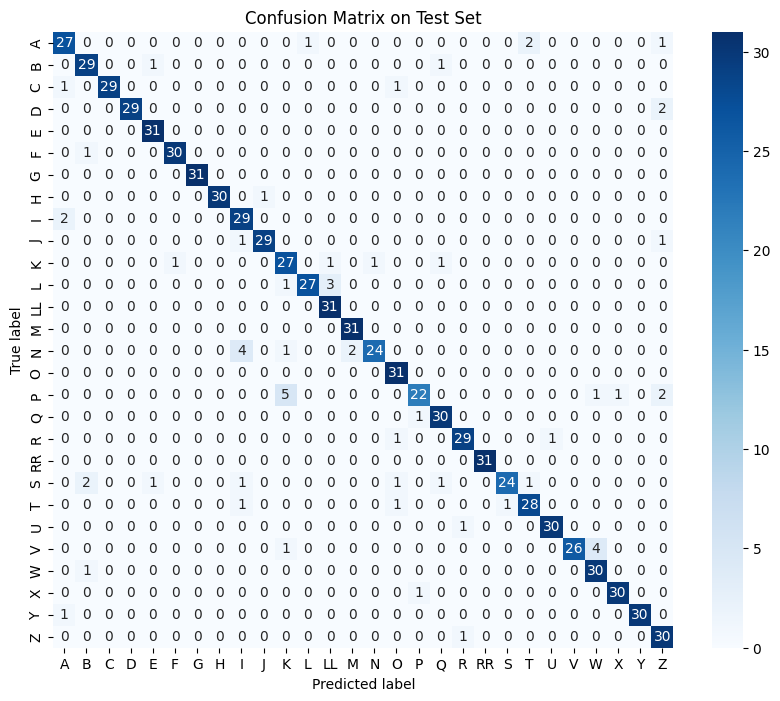

In [12]:
# Showing additional metrics
print("\nClassification Report for MLP:")
y_test_preds = mlp_search.predict(X_test)
cm = confusion_matrix(y_test, y_test_preds, labels=label_encoder.transform(class_names))
plt.figure(figsize=(10,8))
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            xticklabels=class_names.tolist(), 
            yticklabels=class_names.tolist(),
            cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix on Test Set")
plt.show()

In [13]:
report = classification_report(
    y_test, 
    y_test_preds,
    target_names=class_names, 
    digits=4
)
print("Classification Report on Test Set:\n")
print(report)

Classification Report on Test Set:

              precision    recall  f1-score   support

           A     0.8710    0.8710    0.8710        31
           B     0.8788    0.9355    0.9062        31
           C     1.0000    0.9355    0.9667        31
           D     1.0000    0.9355    0.9667        31
           E     0.9394    1.0000    0.9688        31
           F     0.9677    0.9677    0.9677        31
           G     1.0000    1.0000    1.0000        31
           H     1.0000    0.9677    0.9836        31
           I     0.8056    0.9355    0.8657        31
           J     0.9667    0.9355    0.9508        31
           K     0.7714    0.8710    0.8182        31
           L     0.9643    0.8710    0.9153        31
          LL     0.8857    1.0000    0.9394        31
           M     0.9394    1.0000    0.9688        31
           N     0.9600    0.7742    0.8571        31
           O     0.8857    1.0000    0.9394        31
           P     0.9167    0.7097    0.8000  

In [14]:
# Defining parameter distribution
rf_param_dist = {
    "clf__n_estimators":      [100, 200, 500, 1000],
    "clf__max_depth":         [None, 10, 20, 30, 50],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf":  [1, 2, 4]
}

# Building the pipeline
rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf",    RandomForestClassifier(random_state=RANDOM_STATE))
])

# Randomized search
rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

# Fit on the training set
rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)

# Evaluate on validation set
rf_val_preds = rf_search.predict(X_val)

# Compute raw metrics
raw_rf_acc   = accuracy_score(y_val, rf_val_preds)
raw_rf_f1    = f1_score(y_val, rf_val_preds, average="macro")
raw_rf_prec  = precision_score(y_val, rf_val_preds, average="macro")
raw_rf_rec   = recall_score(y_val, rf_val_preds, average="macro")

# Round them
rf_metrics = {
    "accuracy":         round(float(raw_rf_acc), 4),
    "f1_macro":         round(float(raw_rf_f1), 4),
    "precision_macro":  round(float(raw_rf_prec), 4),
    "recall_macro":     round(float(raw_rf_rec), 4)
}

# Displaying information of each Metric
print("RandomForest tuned metrics:")
for name, val in rf_metrics.items():
    print(f"  {name}: {val}")

rf_results_df = pd.DataFrame([rf_metrics], index=["RandomForest"])
display(rf_results_df)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF params: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': 50}
RandomForest tuned metrics:
  accuracy: 0.9286
  f1_macro: 0.9278
  precision_macro: 0.9303
  recall_macro: 0.9286


,accuracy,f1_macro,precision_macro,recall_macro
RandomForest,0.9286,0.9278,0.9303,0.9286



Classification Report for RandomForest:


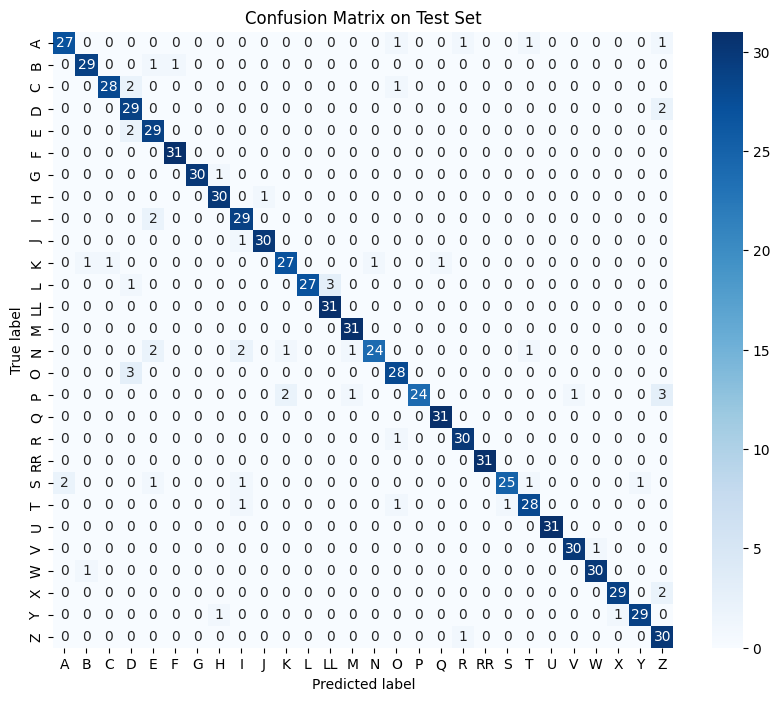

In [15]:
# Showing additional metrics
print("\nClassification Report for RandomForest:")
y_test_preds = rf_search.predict(X_test)
cm = confusion_matrix(y_test, y_test_preds, labels=label_encoder.transform(class_names))
plt.figure(figsize=(10,8))
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            xticklabels=class_names.tolist(), 
            yticklabels=class_names.tolist(),
            cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix on Test Set")
plt.show()

In [16]:
report = classification_report(
    y_test, 
    y_test_preds, 
    target_names=class_names, 
    digits=4
)
print("Classification Report on Test Set:\n")
print(report)

Classification Report on Test Set:

              precision    recall  f1-score   support

           A     0.9310    0.8710    0.9000        31
           B     0.9355    0.9355    0.9355        31
           C     0.9655    0.9032    0.9333        31
           D     0.7838    0.9355    0.8529        31
           E     0.8286    0.9355    0.8788        31
           F     0.9688    1.0000    0.9841        31
           G     1.0000    0.9677    0.9836        31
           H     0.9375    0.9677    0.9524        31
           I     0.8529    0.9355    0.8923        31
           J     0.9677    0.9677    0.9677        31
           K     0.9000    0.8710    0.8852        31
           L     1.0000    0.8710    0.9310        31
          LL     0.9118    1.0000    0.9538        31
           M     0.9394    1.0000    0.9688        31
           N     0.9600    0.7742    0.8571        31
           O     0.8750    0.9032    0.8889        31
           P     1.0000    0.7742    0.8727  

# Homogeneous Ensemble Models

In [17]:
# 4.1 Define parameter grids for BaggingClassifier (with DecisionTree base) 

# 4.2 Perform hyperparameter search for BaggingClassifier, record best_model_bagging and best_params_bagging

# 4.3 Define parameter grids for AdaBoostClassifier

# 4.4 Perform hyperparameter search for AdaBoostClassifier, record best_model_adaboost and best_params_adaboost

# 4.5 (Optional) Define and tune a GradientBoostingClassifier or similar

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
# 4.1 Define BaggingClassifier with a DecisionTree base estimator
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    random_state=42
)

# Parameter grid for the Bagging ensemble
param_grid_bagging = {
    # number of trees in the bagging ensemble
    'n_estimators': [50, 100, 200],

    # fraction of samples drawn to train each base‐estimator
    'max_samples': [0.5, 1.0],

    # fraction of features drawn to train each base‐estimator
    'max_features': [0.5, 1.0],

    # we can also tune the depth of each DecisionTree
    'estimator__max_depth': [None, 10, 20]
}

# 3‐fold CV, optimizing for macro‐averaged F1
grid_bagging = GridSearchCV(
    estimator=bagging,
    param_grid=param_grid_bagging,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# 4.2 Fit and record the best model + parameters + training time
start_time = time.time()
grid_bagging.fit(X_train, y_train)
bagging_fit_time = time.time() - start_time

best_model_bagging = grid_bagging.best_estimator_
best_params_bagging = grid_bagging.best_params_

print(f"Best Bagging params: {best_params_bagging}")
print(f"Bagging training time: {bagging_fit_time:.2f} seconds")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Bagging params: {'estimator__max_depth': 20, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 200}
Bagging training time: 19.02 seconds


In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# 4.3 Define AdaBoost with a shallow DecisionTree base estimator
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    random_state=42
)

# Parameter grid for AdaBoost
param_grid_ada = {
    # number of boosting rounds
    'n_estimators': [50, 100, 200],

    # learning rate of each new tree added
    'learning_rate': [0.01, 0.1, 1.0],

    # tune the depth of each weak learner
    'estimator__max_depth': [1, 3, 5]
}

# 3‐fold CV, optimizing for macro‐averaged F1
grid_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_grid_ada,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# 4.4 Fit and record best model + parameters + training time
start_time = time.time()
grid_ada.fit(X_train, y_train)
ada_fit_time = time.time() - start_time

best_model_adaboost = grid_ada.best_estimator_
best_params_adaboost = grid_ada.best_params_

print(f"Best AdaBoost params: {best_params_adaboost}")
print(f"AdaBoost training time: {ada_fit_time:.2f} seconds")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best AdaBoost params: {'estimator__max_depth': 5, 'learning_rate': 1.0, 'n_estimators': 200}
AdaBoost training time: 17.26 seconds


In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# 4.5 Define GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)

# Parameter grid for GradientBoosting
param_grid_gb = {
    # number of boosting iterations
    'n_estimators': [100, 200],

    # learning rate for shrinkage
    'learning_rate': [0.01, 0.1],

    # depth of each tree
    'max_depth': [3, 5, 7]
}

# 3‐fold CV optimizing f1_macro
grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Fit and record best model + params + training time
start_time = time.time()
grid_gb.fit(X_train, y_train)
gb_fit_time = time.time() - start_time

best_model_gb = grid_gb.best_estimator_
best_params_gb = grid_gb.best_params_

print(f"Best GradientBoosting params: {best_params_gb}")
print(f"GradientBoosting training time: {gb_fit_time:.2f} seconds")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best GradientBoosting params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
GradientBoosting training time: 266.25 seconds


# Heterogeneous Ensemble Models (Stacking & Blending)

In [22]:
# 5.1.1 Define base learner list, e.g. [
#      ('rf', best_model_rf),
#      ('xgb', best_model_xgb),
#      ('svm', best_model_svm),
#      ('lr', best_model_lr)
# ]

# 5.1.2 Implement function to generate out-of-fold predictions for each base model

# 5.1.3 Create training dataset for meta_learner using out-of-fold predictions

# 5.1.4 Tune meta-learner (e.g., LogisticRegression) using the stacked features

# 5.1.5 Train final stacking model: re-fit base models on full training set, then fit meta-learner on predicted training probabilities


In [ ]:
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression

# 5.1.1 Define base learner list using your fitted pipelines
base_learners = [
    ("mlp",  fitted_pipelines["MLP"]),
    ("rf",   fitted_pipelines["RandomForest"]),
    ("knn",  fitted_pipelines["KNN"]),
    ("svm",  fitted_pipelines["SVM"])   # SVM was re-trained with probability=True
]

# Number of classes (for a multiclass problem)
n_classes = len(np.unique(y_train))

# 5.1.2 & 5.1.3: Generate out‐of‐fold predictions for each base model
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Prepare an array to hold OOF probabilities:
# shape = (n_samples_train, n_learners * n_classes)
meta_X = np.zeros((X_train.shape[0], len(base_learners) * n_classes))

for i, (name, model) in enumerate(base_learners):
    # This array will hold the OOF probabilities for this one model
    oof_preds = np.zeros((X_train.shape[0], n_classes))
    
    for train_idx, val_idx in kf.split(X_train):
        # Select rows for this fold
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr = y_train[train_idx]          # y_train is a numpy array
       
        # Clone the fitted pipeline so we retrain from scratch each fold
        cloned = clone(model)
        cloned.fit(X_tr, y_tr)
        
        # Predict probabilities on the validation fold
        oof_preds[val_idx] = cloned.predict_proba(X_val)
    
    # Place this model’s OOF probabilities into the correct columns of meta_X
    start_col = i * n_classes
    end_col   = start_col + n_classes
    meta_X[:, start_col:end_col] = oof_preds

# 5.1.4 Tune meta‐learner (LogisticRegression) on the stacked features
param_grid_meta = {"C": [0.01, 0.1, 1.0, 10.0]}

meta_clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)

grid_meta = GridSearchCV(
    estimator=meta_clf,
    param_grid=param_grid_meta,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)
grid_meta.fit(meta_X, y_train)
best_meta = grid_meta.best_estimator_
print("Best meta‐learner params:", grid_meta.best_params_)

# 5.1.5 Refit each base learner on the full training set
for name, model in base_learners:
    model.fit(X_train, y_train)

# Refit the meta‐learner on the full OOF feature matrix
best_meta.fit(meta_X, y_train)

# --------------
# Utility functions for inference
# --------------
def get_stacked_features(X):
    """
    Given new data X, returns the "stacked" feature matrix
    by concatenating predict_proba outputs from each base learner.
    """
    all_probs = []
    for name, model in base_learners:
        probs = model.predict_proba(X)   # shape = (n_samples_new, n_classes)
        all_probs.append(probs)
    return np.hstack(all_probs)

def stacked_predict_proba(X):
    """
    Returns probability predictions for new data X using the stacked model:
      1. Compute each base learner’s predict_proba(X).
      2. Concatenate those into a meta‐feature matrix.
      3. Feed meta‐features into the meta‐learner.
    """
    meta_features = get_stacked_features(X)
    return best_meta.predict_proba(meta_features)

def stacked_predict(X):
    """
    Returns final class predictions by taking argmax on stacked_predict_proba.
    """
    probs = stacked_predict_proba(X)
    return np.argmax(probs, axis=1)

# Example: Evaluate stacked ensemble on validation set
# y_val_preds = stacked_predict(X_val)
# y_val_probs = stacked_predict_proba(X_val)
# Then compute accuracy, f1_macro, etc. as usual.


# 5.2 Blending Ensemble

Describe how you will split off a holdout “blending set” from training.

Explain that base learners are trained on the remaining portion.

Show how you will collect predictions on the blending set, then train a meta‐learner.

In [ ]:
# 5.2.1 Split off blending_set X_blend, y_blend from train data

# 5.2.2 Train each base learner on train \ blending_set

# 5.2.3 Generate predictions on X_blend for each base learner, create blend_features

# 5.2.4 Fit meta-learner (e.g., LogisticRegression) on blend_features and y_blend

# 5.2.5 Define a function to perform blending inference on new data


# Evaluation & Comparative Table

Describe how you will evaluate each model on the test set.

List all metrics you will compute (e.g., ROC AUC, accuracy, precision, recall, F1, training time).

Explain that you will assemble a DataFrame to summarize results.

In [ ]:
# 6.1 Define a function to compute performance metrics for a model: 
#      - model.predict_proba(X_test) → compute ROC AUC, PR AUC
#      - model.predict(X_test) → compute accuracy, precision, recall, F1
#      - measure training_time (already recorded), optionally measure inference_time

# 6.2 Apply this evaluation function to:
#      - Best single Phase I model
#      - Homogeneous ensemble 1 (best_model_bagging)
#      - Homogeneous ensemble 2 (best_model_adaboost)
#      - (Optional) Homogeneous ensemble 3
#      - Stacked ensemble
#      - Blended ensemble

# 6.3 Create a pandas DataFrame summarizing all results:
#      columns=['Model','ROC_AUC','Accuracy','Precision','Recall','F1','Training_Time_s']

# 6.4 Sort DataFrame by 'ROC_AUC' descending

# 6.5 Display the table


# Final Model Selection & Justification

Present the sorted comparison table from Section 6.

Write a paragraph explaining which model you choose and why, referencing:

The primary metric

Secondary metrics

Training/inference times

Business requirements (e.g., interpretability, deployment constraints)

# Diagnostic Plots for Final Chosen Model

List the four (or more) plots you will generate. For each, describe what it shows and why it is important.

In [ ]:
# 8.1.1 Compute y_proba = final_model.predict_proba(X_test)[:,1]
# 8.1.2 Use sklearn.metrics.roc_curve and roc_auc_score to get FPR, TPR, AUC
# 8.1.3 Plot with matplotlib: plt.plot(FPR, TPR), plt.title('ROC Curve')


Confusion Matrix

In [ ]:
# 8.2.1 Compute y_pred = final_model.predict(X_test)
# 8.2.2 Use sklearn.metrics.confusion_matrix to get cm
# 8.2.3 Plot cm with seaborn.heatmap


Precision-Recall Curve

In [ ]:
# 8.3.1 Use sklearn.metrics.precision_recall_curve on y_test, y_proba
# 8.3.2 Plot precision vs. recall
# 8.3.3 Compute PR AUC if desired (sklearn.metrics.average_precision_score)


Feature Importance (Bar Plot)

In [ ]:
# 8.4.1 If final_model has feature_importances_ attribute:
#       importances = final_model.feature_importances_
# 8.4.2 Select top 10 indices, sort by importance
# 8.4.3 Plot bar chart with matplotlib or seaborn


(Optional) Residual Analysis or Tree Diagram

In [ ]:
# 8.5.1 Compute residuals = y_test - y_pred
# 8.5.2 Plot residuals vs y_pred with plt.scatter


Check for patterns indicating heteroscedasticity or bias.

If final model is a decision tree (or if you want to show one tree from a Random Forest):

In [ ]:
# 8.5.3 Use sklearn.tree.plot_tree to visualize one tree

# Conclusions & Next Steps

Summarize what you did:

Built four ensemble models (two homogeneous, two heterogeneous).

Compared them to the best individual model.

Chose a final model based on performance, complexity, and business constraints.

Provided diagnostic plots with interpretation.

Restate why the selected model is the best fit.

Outline monitoring strategy in production (e.g., track AUC monthly, detect data drift).

Suggest future improvements (e.g., adding new features, retraining schedule, exploring cost‐sensitive learning).